In [22]:
import argparse
import glob
import json
import os

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
import wandb
from PIL import Image
from albumentations.pytorch import ToTensorV2

from src.models.regnety.regnety import RegNetY
from src.utils.transform_utils import load_transforms

In [23]:
api = wandb.Api()
run = api.run(f'mvrcii_/SEER/5wqhpp88')
config = argparse.Namespace(**run.config)

In [18]:
transforms_str = run.summary.get('transforms')
_, val_transform = load_transforms(img_size=config.img_size, transforms_string=transforms_str)
base_transform = val_transform

In [11]:
# Project paths
vissl_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\\vissl'
endoscopy_project_dir = 'C:\\Users\Marce\Git-Master\JMU\Masterarbeit\endoscopy'
cvip_project_dir = 'C:\\Users\Marce\Git-Master\Privat\cv2024'

In [12]:
class_mapping_path = os.path.join(endoscopy_project_dir, 'datasets/endoextend_dataset/class_mapping.json')
absolute_path = os.path.abspath(class_mapping_path)
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

In [13]:
ckpt_filename = 'best_epoch01_val_mAP_weighted0.67.ckpt'
ckpt_path = os.path.join(cvip_project_dir, 'pretrained_models', ckpt_filename)

model = RegNetY.load_from_checkpoint(checkpoint_path=ckpt_path, config=config, class_to_idx=class_mapping)
model.to(torch.device('cuda'))
model.eval();

In [24]:
def revert_transformations(tensor):
    """Revert transformations applied during preprocessing, mainly normalization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    tensor.mul_(std).add_(mean)  # Revert normalization
    return TF.to_pil_image(tensor.cpu())  # Convert to PIL Image for visualization

In [25]:
def load_and_transform_image(image_path, transform):
    with Image.open(image_path) as img:
        return transform(image=np.array(img.convert('RGB')))['image'].to(torch.device('cuda'))

In [27]:
def predict_image(model, val_transform, image_path):
    img_tensor = load_and_transform_image(image_path, val_transform)
    with torch.no_grad():
        logits = model(img_tensor.unsqueeze(0)).squeeze()
        preds = logits.argmax(dim=0).cpu().numpy()
        probs = torch.softmax(logits, dim=0).detach().cpu().numpy()
        return preds, img_tensor, probs

In [28]:
def list_image_files(path: str, extensions=None) -> list:
    """List all image files in a directory, handling multiple extensions."""
    if extensions is None:
        extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.gif']
    images = []
    for extension in extensions:
        images.extend(glob.glob(os.path.join(path, '**', '*' + extension), recursive=True))
    return images

In [29]:
def idx_to_label(idx, class_mapping):
    return {v: k for k, v in class_mapping.items()}[idx]

In [30]:
# Load all foreign_body images
cvip_imgs = list_image_files('cvip')
ee_imgs = list_image_files('endoextend')

# Identify common filenames
filenames1 = {os.path.basename(path) for path in cvip_imgs}
filenames2 = {os.path.basename(path) for path in ee_imgs}
common_filenames = filenames1.intersection(filenames2)

# Extract common images
cvip_images = [path for path in cvip_imgs if os.path.basename(path) in common_filenames]
ee_images = [path for path in ee_imgs if os.path.basename(path) in common_filenames]

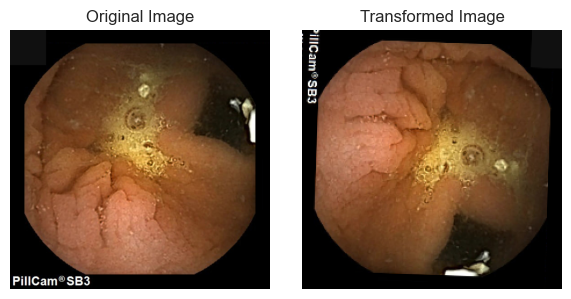

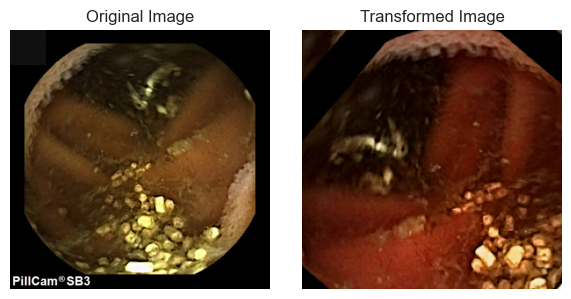

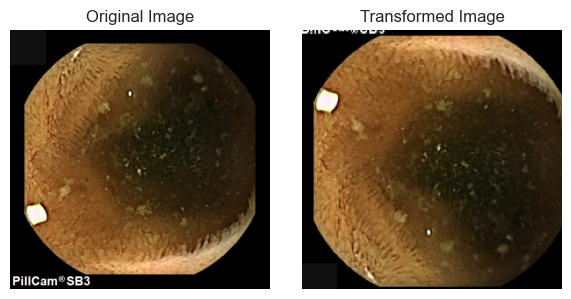

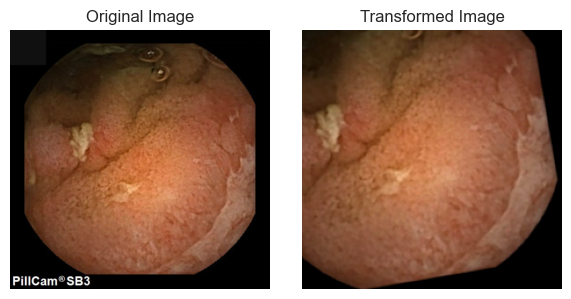

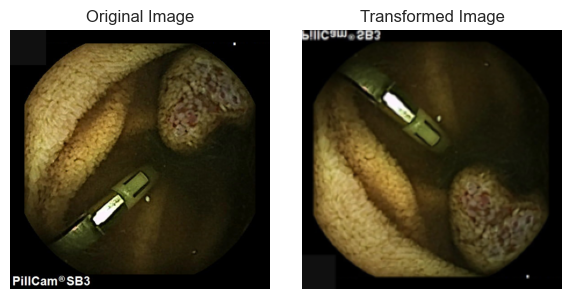

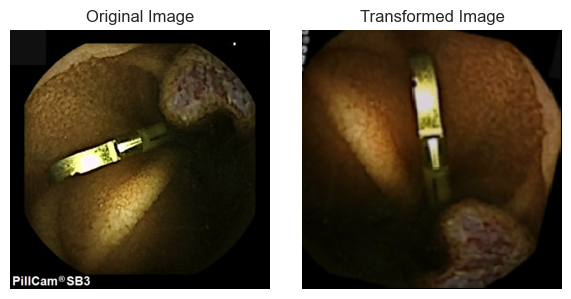

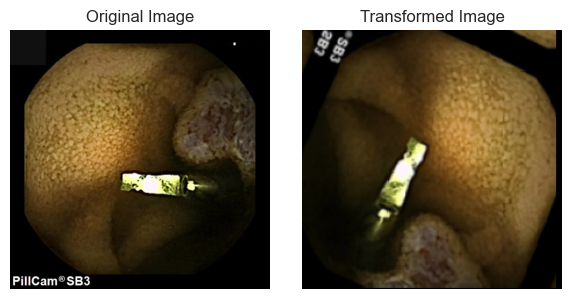

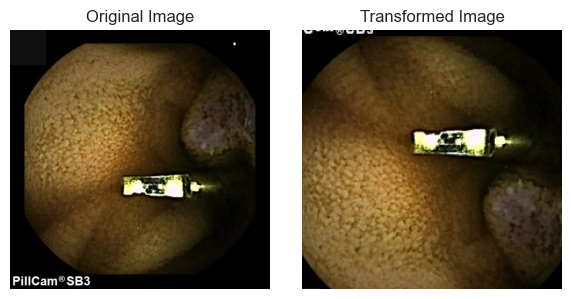

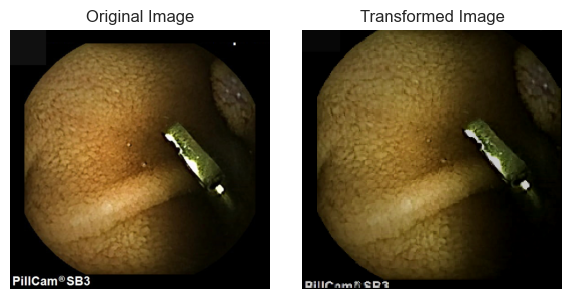

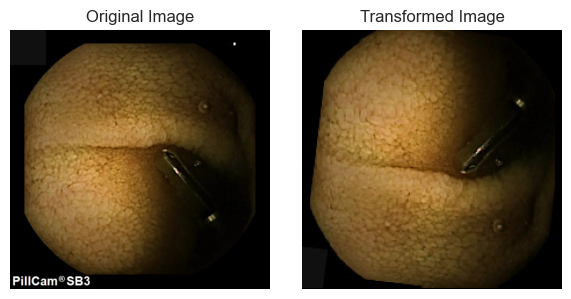

In [90]:
img_size = 224
train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=(-180, 180)),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=2.55),
    A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.5, 1.0), ratio=(1.0, 1.0), interpolation=1),
    A.Resize(height=img_size, width=img_size, interpolation=4),
    A.GridDistortion(num_steps=3, distort_limit=(-0.09, 0.09), interpolation=0, border_mode=0),
    A.ColorJitter(p=0.5, brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05)),
    ToTensorV2()
])


def plot_image(img_orig, img_trans):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    ax[0].imshow(img_orig)
    ax[0].set_title(f'Original Image')
    ax[0].axis('off')

    ax[1].imshow(img_trans)
    ax[1].set_title(f'Transformed Image')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()


all_images = ee_images
for i in range(0, 10):
    image_tensor = load_and_transform_image(all_images[i], train_transforms)
    img_trans = TF.to_pil_image(image_tensor.cpu())
    img_orig = Image.open(all_images[i])
    plot_image(img_orig, img_trans)